# Lambda Rank

You are getting the same 的中率 as the person writing this blog:

https://note.com/dataij/n/n5a6d121b13ab

But the 参考回収率 they write is much higher.

In [1]:
import tempfile

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import shap
import tqdm
import trueskill
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tqdm import tqdm

from JapanHorseRaceAnalytics.utilities.base import (
    get_random_seed,
    get_spark_session,
    read_hive_table,
)
from JapanHorseRaceAnalytics.utilities.metrics import kelly_criterion
from JapanHorseRaceAnalytics.utilities.plot import plot_feature_importances
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

japanize_matplotlib.japanize()

In [2]:
spark = get_spark_session()

24/03/23 17:04:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/23 17:04:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
    parse_dates=["meta_発走日時"],
)

rows_before = data.shape[0]
logger.info(f"Original data length: {rows_before}")

# Drop from data where cat_トラック種別 == "障害"
# Keep only horses that have 3 races
# Keep only data from 2000 onwards
data = data[
    # (data["cat_トラック種別"] != "障害")
    (~data["meta_着順"].isna())
    # & (data["meta_異常区分"] == "0")
    # & (data["num_1走前着順"].notnull())
    # & (data["num_2走前着順"].notnull())
    # & (data["num_3走前着順"].notnull())
    # & (data["meta_発走日時"] >= "2000-01-01")
]

rows_after = data.shape[0]
logger.info(
    f"Data length after filtering: {rows_after} (dropped {rows_before - rows_after} rows, {100 * (rows_before - rows_after) / rows_before:.2f}%)"
)

# Interpolate missing values for num_馬体重 (20 instances from 1999 ~ 2017)
data["num_馬体重"] = (
    data.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["num_馬体重"]
    .transform(lambda x: x.interpolate(method="linear", limit_direction="both"))
)

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from hive jhra_curated.features_20240304_v1", "level": "info", "timestamp": "2024-03-23T04:29:33.956249Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
24/03/23 13:29:34 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/03/23 13:29:34 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/03/23 13:29:35 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
{"event": "Write to parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet", "level": "info", "timestamp": "2024-03-23T04:29:35.956812Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
24/03/23 13:29:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_2024030

,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_単勝オッズ,meta_複勝的中,meta_複勝オッズ,...,cat_3走前休養理由分類コード,num_3走前3着タイム差,cat_トラック種別,num_距離,cat_距離区分,num_入厩何日前逆数,cat_堅実な馬,cat_過去3走中1走訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,0,0,09025206,11,00100027,2002-12-01 12:45:00+09:00,0,38.6,0,4.4,...,None,NaN,芝,1600,マイル,1.0,False,False,False,False
1,0,0,08032303,04,00100027,2003-02-08 10:55:00+09:00,0,39.5,0,11.8,...,None,NaN,ダート,1800,中距離,1.0,False,False,False,False
2,0,0,08032801,14,00100027,2003-02-23 10:00:00+09:00,0,31.0,0,3.7,...,None,NaN,ダート,1800,中距離,1.0,False,False,False,False
3,0,0,09031403,07,00100027,2003-03-09 10:55:00+09:00,0,17.2,0,2.3,...,None,1.4,ダート,1800,中距離,1.0,False,False,False,False
4,0,0,09031701,10,00100027,2003-03-22 10:05:00+09:00,0,20.8,0,2.7,...,None,1.1,ダート,1800,中距離,1.0,False,False,False,False


In [3]:
# Initialize ratings for all horses under each condition, plus an overall rating
conditions = [
    "overall",
    "turf",
    "dirt",
    "sprint",
    "mile",
    "middle_distance",
    "intermediate_distance",
    "long_distance",
    "firm",  # 良
    "good",  # 稍重
    "yielding",  # 重
    "soft",  # 不良
]

# Initialize the TrueSkill environment
env = trueskill.TrueSkill(draw_probability=0)  # Assuming no draws in horse racing

In [4]:
df_sorted = data.sort_values(by=["meta_発走日時", "meta_レースキー"])

horse_ratings = {
    horse_id: {condition: env.create_rating() for condition in conditions}
    for horse_id in df_sorted["meta_血統登録番号"].unique()
}

# Placeholder for ratings at each point in time for each condition, including overall
df_sorted["race_overall_quality"] = pd.NA
for condition in conditions:
    df_sorted[f"rating_{condition}_post_race"] = pd.NA
    df_sorted[f"rating_{condition}_uncertainty_post_race"] = pd.NA


# Function to determine the active conditions for a race, considering overall
def get_active_conditions(row):
    active_conditions = ["overall"]

    if row["cat_トラック種別"] == "芝":
        active_conditions.append("turf")
    elif row["cat_トラック種別"] == "ダート":
        active_conditions.append("dirt")

    if row["cat_距離区分"] == "短距離":
        active_conditions.append("sprint")
    elif row["cat_距離区分"] == "マイル":
        active_conditions.append("mile")
    elif row["cat_距離区分"] == "中距離":
        active_conditions.append("middle_distance")
    elif row["cat_距離区分"] == "中長距離":
        active_conditions.append("intermediate_distance")
    elif row["cat_距離区分"] == "長距離":
        active_conditions.append("long_distance")
    
    if row["cat_馬場状態"] == "良":
        active_conditions.append("firm")
    elif row["cat_馬場状態"] == "稍重":
        active_conditions.append("good")
    elif row["cat_馬場状態"] == "重":
        active_conditions.append("yielding")
    elif row["cat_馬場状態"] == "不良":
        active_conditions.append("soft")

    return active_conditions


# Iterate through races in chronological order
for (_, race_id), race_data in tqdm(df_sorted.groupby(["meta_発走日時", "meta_レースキー"])):
    race_results = race_data.sort_values("meta_着順")
    horse_ids = race_results["meta_血統登録番号"].tolist()

    # Determine active conditions for this race
    active_conditions = get_active_conditions(race_data.iloc[0])

    # Measure race quality
    # 0 means significant disparity in skill levels, 1 means very close match
    horse_groups = [[horse_ratings[horse_id]["overall"]] for horse_id in horse_ids]
    df_sorted.loc[race_results.index, "race_overall_quality"] = env.quality(horse_groups)

    # For each condition (including overall), update and record ratings
    for condition in active_conditions:
        horse_groups = [[horse_ratings[horse_id][condition]] for horse_id in horse_ids]
        # Lower rank number means a better position
        ranks = list(range(len(horse_groups)))

        # Update ratings based on the race outcome for each condition
        updated_ratings = env.rate(horse_groups, ranks=ranks)

        # Apply updates to the horse ratings and DataFrame
        for index, (horse_id, new_rating_group) in zip(race_results.index, zip(horse_ids, updated_ratings)):
            # Update ratings in the horse_ratings dictionary for the current condition
            horse_ratings[horse_id][condition] = new_rating_group[0]

            # Store the updated rating in the DataFrame for the current condition
            df_sorted.at[index, f"rating_{condition}_post_race"] = horse_ratings[horse_id][condition].mu
            df_sorted.at[index, f"rating_{condition}_uncertainty_post_race"] = horse_ratings[horse_id][condition].sigma

# Note: At this point, df_sorted contains the updated post-race ratings for each horse under each condition present in the race, including the overall performance.

100%|██████████| 86237/86237 [43:24<00:00, 33.11it/s]  


In [4]:
# df_sorted.to_parquet(
#     "data/sql_tables/features_20240304_v1_with_ratings.snappy.parquet",
#     index=False,
#     compression="snappy",
# )
df_sorted = pd.read_parquet("data/sql_tables/features_20240304_v1_with_ratings.snappy.parquet")

In [5]:
for condition in tqdm(conditions):
    # Lag the rating_post_race by one row per horse (meta_血統登録番号) chronologically (meta_発走日時)
    df_sorted[f"rating_{condition}_pre_race"] = (
        df_sorted.sort_values("meta_発走日時")
        .groupby("meta_血統登録番号")[f"rating_{condition}_post_race"]
        .shift(1)
        .fillna(env.mu)
    )

    df_sorted[f"rating_{condition}_uncertainty_pre_race"] = (
        df_sorted.sort_values("meta_発走日時")
        .groupby("meta_血統登録番号")[f"rating_{condition}_uncertainty_post_race"]
        .shift(1)
        .fillna(env.sigma)
    )

# Now we have pre_race ratings and uncertainties for each horse under each condition, including overall

100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


In [6]:
#
# DISTANCE
#

distance_conditions = [
    df_sorted["cat_距離区分"] == "短距離",
    df_sorted["cat_距離区分"] == "マイル",
    df_sorted["cat_距離区分"] == "中距離",
    df_sorted["cat_距離区分"] == "中長距離",
    df_sorted["cat_距離区分"] == "長距離",
]

distance_choices = [
    df_sorted["rating_sprint_pre_race"],
    df_sorted["rating_mile_pre_race"],
    df_sorted["rating_middle_distance_pre_race"],
    df_sorted["rating_intermediate_distance_pre_race"],
    df_sorted["rating_long_distance_pre_race"],
]

distance_uncertainty_choices = [
    df_sorted["rating_sprint_uncertainty_pre_race"],
    df_sorted["rating_mile_uncertainty_pre_race"],
    df_sorted["rating_middle_distance_uncertainty_pre_race"],
    df_sorted["rating_intermediate_distance_uncertainty_pre_race"],
    df_sorted["rating_long_distance_uncertainty_pre_race"],
]

df_sorted["rating_距離区分_pre_race"] = np.select(distance_conditions, distance_choices, default=np.nan)
df_sorted["rating_距離区分_uncertainty_pre_race"] = np.select(distance_conditions, distance_uncertainty_choices, default=np.nan)

#
# SURFACE TYPE
#

turf_conditions = [
    df_sorted["cat_トラック種別"] == "芝",
    df_sorted["cat_トラック種別"] == "ダート",
]

turf_choices = [
    df_sorted["rating_turf_pre_race"],
    df_sorted["rating_dirt_pre_race"],
]

turf_uncertainty_choices = [
    df_sorted["rating_turf_uncertainty_pre_race"],
    df_sorted["rating_dirt_uncertainty_pre_race"],
]

df_sorted["rating_トラック種別_pre_race"] = np.select(turf_conditions, turf_choices, default=np.nan)
df_sorted["rating_トラック種別_uncertainty_pre_race"] = np.select(turf_conditions, turf_uncertainty_choices, default=np.nan)

#
# GOING
#

going_conditions = [
    df_sorted["cat_馬場状態"] == "良",
    df_sorted["cat_馬場状態"] == "稍重",
    df_sorted["cat_馬場状態"] == "重",
    df_sorted["cat_馬場状態"] == "不良",
]

going_choices = [
    df_sorted["rating_firm_pre_race"],
    df_sorted["rating_good_pre_race"],
    df_sorted["rating_yielding_pre_race"],
    df_sorted["rating_soft_pre_race"],
]

going_uncertainty_choices = [
    df_sorted["rating_firm_uncertainty_pre_race"],
    df_sorted["rating_good_uncertainty_pre_race"],
    df_sorted["rating_yielding_uncertainty_pre_race"],
    df_sorted["rating_soft_uncertainty_pre_race"],
]

df_sorted["rating_馬場状態_pre_race"] = np.select(going_conditions, going_choices, default=np.nan)
df_sorted["rating_馬場状態_uncertainty_pre_race"] = np.select(going_conditions, going_uncertainty_choices, default=np.nan)

#
# MEAN DIFFS
#

for category in ["overall", "距離区分", "トラック種別", "馬場状態"]:
    race_rating_sum = df_sorted.groupby("meta_レースキー")[f"rating_{category}_pre_race"].transform("sum")
    race_horse_count = df_sorted.groupby("meta_レースキー")[f"rating_{category}_pre_race"].transform("count")
    df_sorted[f"mean_competitor_rating_{category}_pre_race"] = (race_rating_sum - df_sorted[f"rating_{category}_pre_race"]) / (race_horse_count - 1)
    df_sorted[f"mean_competitor_rating_{category}_pre_race_diff"] = df_sorted[f"rating_{category}_pre_race"] - df_sorted[f"mean_competitor_rating_{category}_pre_race"]

    race_rating_uncertainty_sum = df_sorted.groupby("meta_レースキー")[f"rating_{category}_uncertainty_pre_race"].transform("sum")
    race_horse_count = df_sorted.groupby("meta_レースキー")[f"rating_{category}_uncertainty_pre_race"].transform("count")
    df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race"] = (race_rating_uncertainty_sum - df_sorted[f"rating_{category}_uncertainty_pre_race"]) / (race_horse_count - 1)
    df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race_diff"] = df_sorted[f"rating_{category}_uncertainty_pre_race"] - df_sorted[f"mean_competitor_rating_{category}_uncertainty_pre_race"]

# Use the following columns as features
# rating_{category}_pre_race
# rating_{category}_uncertainty_pre_race
# mean_competitor_rating_{category}_pre_race_diff
# mean_competitor_rating_{category}_uncertainty_pre_race_diff


# Looks good
df_sorted[
    [
        "cat_トラック種別",
        "rating_turf_pre_race",
        "rating_turf_uncertainty_pre_race",
        "rating_dirt_pre_race",
        "rating_dirt_uncertainty_pre_race",
        "rating_トラック種別_pre_race",
        "rating_トラック種別_uncertainty_pre_race",
        "mean_competitor_rating_トラック種別_pre_race_diff",
        "mean_competitor_rating_トラック種別_uncertainty_pre_race_diff",
    ]
].sample(10)

,cat_トラック種別,rating_turf_pre_race,rating_turf_uncertainty_pre_race,rating_dirt_pre_race,rating_dirt_uncertainty_pre_race,rating_トラック種別_pre_race,rating_トラック種別_uncertainty_pre_race,mean_competitor_rating_トラック種別_pre_race_diff,mean_competitor_rating_トラック種別_uncertainty_pre_race_diff
45769,ダート,21.397378,4.927590,25.000000,8.333333,25.000000,8.333333,-4.135266,2.904795
32223,芝,28.108147,1.538139,25.000000,8.333333,28.108147,1.538139,1.814954,-1.831198
749669,芝,25.000000,8.333333,25.000000,8.333333,25.000000,8.333333,0.000000,0.000000
799687,芝,25.000000,8.333333,25.000000,8.333333,25.000000,8.333333,0.000000,0.000000
763216,ダート,22.359518,4.996491,25.000000,8.333333,25.000000,8.333333,-9.936804,5.893424
627873,ダート,25.000000,8.333333,19.604102,3.421661,19.604102,3.421661,-5.827718,-0.874236
749613,芝,25.000000,8.333333,25.000000,8.333333,25.000000,8.333333,0.000000,0.000000
1166174,芝,25.000000,8.333333,30.645244,1.706162,25.000000,8.333333,-3.409988,5.252728
1175563,芝,37.628806,2.783922,25.000000,8.333333,37.628806,2.783922,4.375993,-0.405076
389757,芝,44.063093,2.662773,25.000000,8.333333,44.063093,2.662773,4.890326,1.635144


In [7]:
# Calculate the average 1走前経過日数 for each horse's competitors in the same race, excluding the horse itself. Store in "mean_competitor_1走前経過日数" column.
race_sums = df_sorted.groupby('meta_レースキー')['num_1走前経過日数'].transform('sum')
race_counts = df_sorted.groupby('meta_レースキー')['num_1走前経過日数'].transform('count')
# Calculate the average for competitors of each horse
df_sorted['mean_competitor_1走前経過日数'] = (race_sums - df_sorted['num_1走前経過日数']) / (race_counts - 1)

In [8]:
df_final = df_sorted[
    (df_sorted["cat_トラック種別"] != "障害")
    # & (df_sorted["num_1走前着順"].notnull())
    # & (df_sorted["num_2走前着順"].notnull())
    # & (df_sorted["num_3走前着順"].notnull())
    # & (df_sorted["num_平均馬体重差"].notnull())  # only 7 records, handle later
    # & (df_sorted["mean_competitor_1走前経過日数"].notnull())  # 1 row
]

In [9]:
df = df_final.copy()

# 1. Weighted average position
df["num_1走前標準化着順"] = (df["num_1走前着順"] - 1) / (df["num_1走前頭数"] - 1)
df["num_2走前標準化着順"] = (df["num_2走前着順"] - 1) / (df["num_2走前頭数"] - 1)
df["num_3走前標準化着順"] = (df["num_3走前着順"] - 1) / (df["num_3走前頭数"] - 1)
# We want our factor (num_1走前経過日数) to start from 0
# so subtract the minimum value for "days since last race" across all horses
# Add a small number to avoid division by zero
df["num_1走前重み"] = 1 / (df["num_1走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
df["num_2走前重み"] = 1 / (df["num_2走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
df["num_3走前重み"] = 1 / (df["num_3走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
# Calculate weighted average of the feature
df["num_過去3走重み付き標準化着順"] = (
    (df["num_1走前標準化着順"] * df["num_1走前重み"])
    + (df["num_2走前標準化着順"] * df["num_2走前重み"])
    + (df["num_3走前標準化着順"] * df["num_3走前重み"])
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

# 2. Weighted average time difference between the horse and the 3 horses behind it
df["num_1走前後続馬平均タイム差"] = (
    df[["num_1走前後続馬1タイム差", "num_1走前後続馬2タイム差", "num_1走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_2走前後続馬平均タイム差"] = (
    df[["num_2走前後続馬1タイム差", "num_2走前後続馬2タイム差", "num_2走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_3走前後続馬平均タイム差"] = (
    df[["num_3走前後続馬1タイム差", "num_3走前後続馬2タイム差", "num_3走前後続馬3タイム差"]]
    .mean(axis=1)
    .fillna(0)
)
df["num_過去3走重み付き後続馬平均タイム差"] = (
    (df["num_1走前後続馬平均タイム差"] * df["num_1走前重み"])
    + (df["num_2走前後続馬平均タイム差"] * df["num_2走前重み"])
    + (df["num_3走前後続馬平均タイム差"] * df["num_3走前重み"])
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

In [10]:
# Get the average of "rating_距離区分_pre_race", "rating_トラック種別_pre_race", "rating_馬場状態_pre_race" for each row in df and store it as a new column "foo"
df["rating_適性_pre_race"] = df[
    [
        "rating_距離区分_pre_race",
        "rating_トラック種別_pre_race",
        "rating_馬場状態_pre_race",
    ]
].mean(axis=1)

df["mean_competitor_rating_適性_pre_race_diff"] = df[
    [
        "mean_competitor_rating_距離区分_pre_race_diff",
        "mean_competitor_rating_トラック種別_pre_race_diff",
        "mean_competitor_rating_馬場状態_pre_race_diff",
    ]
].mean(axis=1)

In [11]:
# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=get_random_seed())

# Assume df['group'] is your grouping variable
# Splitting the data
for train_idx, test_idx in gss.split(df, groups=df["meta_レースキー"]):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

# Now, train_df and test_df contain your split data, respecting group boundaries
X_train = train_df
y_train = train_df["meta_着順"].apply(lambda x: int(1.0 / x * 10) if x < 4 else 0)
groups_train = train_df.groupby("meta_レースキー").size().to_numpy()

X_test = test_df
y_test = test_df["meta_着順"].apply(lambda x: int(1.0 / x * 10) if x < 4 else 0)
groups_test = test_df.groupby("meta_レースキー").size().to_numpy()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"groups_train: {groups_train.shape}")
print(f"groups_test: {groups_test.shape}")

X_train: (934708, 202)
X_test: (233279, 202)
y_train: (934708,)
y_test: (233279,)
groups_train: (66386,)
groups_test: (16597,)


In [13]:
def calculate_average_ndcg(model, valid_dataset) -> float:
    y_pred = model.predict(valid_dataset.data)

    ## Initialize an empty list to store the NDCG scores of each group
    ndcg_scores = []
    # The starting index of the first item in the current group
    start_idx = 0
    for group_size in valid_dataset.group:
        end_idx = start_idx + group_size
        # Slice the true labels and predictions according to the current group
        true_labels = valid_dataset.label[start_idx:end_idx]
        predictions = y_pred[start_idx:end_idx]

        # Calculate the NDCG score for the current group.
        # ndcg_score expects 2D arrays, so we add an extra dimension
        ndcg = ndcg_score([true_labels], [predictions])
        ndcg_scores.append(ndcg)

        # Update the start index for the next group
        start_idx = end_idx

    # Calculate the average NDCG score across all groups
    return np.mean(ndcg_scores)


def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    groups_train: np.ndarray,
    groups_test: np.ndarray,
    experiment_name: str,
):
    def objective(params):
        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            preprocessor = ColumnTransformer(
                transformers=[
                    (
                        "ord",
                        OrdinalEncoder(categories=[["良", "稍重", "重", "不良"]]),
                        ["cat_馬場状態"],
                    ),
                    (
                        "cat",
                        OneHotEncoder(drop="if_binary"),
                        ["cat_トラック種別", "cat_性別"],
                    ),
                    (
                        "num",
                        StandardScaler(),
                        [
                            "num_馬体重",
                            "num_頭数",
                            "num_負担重量",
                            "num_年齢",
                            "num_距離",
                            "num_平均馬体重差",
                            "num_複勝率",
                            "num_1走前経過日数",
                            "mean_competitor_1走前経過日数",
                            "num_過去3走重み付き標準化着順",
                            "num_過去3走重み付き後続馬平均タイム差",
                            "race_overall_quality",
                            "rating_overall_uncertainty_pre_race",
                            "mean_competitor_rating_overall_pre_race_diff",
                        ],
                    ),
                ],
                remainder="drop",
                verbose_feature_names_out=False,
            )

            X_train_prep = preprocessor.fit_transform(X_train)
            X_test_prep = preprocessor.transform(X_test)

            feature_names = preprocessor.get_feature_names_out().tolist()
            categorical_features = [
                *preprocessor.named_transformers_["ord"]
                .get_feature_names_out()
                .tolist(),
                *preprocessor.named_transformers_["cat"]
                .get_feature_names_out()
                .tolist(),
            ]

            train_dataset = lgb.Dataset(
                X_train_prep,
                label=y_train,
                group=groups_train,
                feature_name=feature_names,
                categorical_feature=categorical_features,
            )
            valid_dataset = lgb.Dataset(
                data=X_test_prep,
                label=y_test,
                group=groups_test,
                reference=train_dataset,
                free_raw_data=False,
                feature_name=feature_names,
                categorical_feature=categorical_features,
            )
            model = lgb.train(
                params,
                train_dataset,
                valid_sets=[valid_dataset],
                num_boost_round=1000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                ],
            )

            # 1 means perfect ranking, 0 means worst ranking
            average_ndcg = calculate_average_ndcg(model, valid_dataset)
            loss = -average_ndcg

            mlflow.log_params(params)
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("average_ndcg", average_ndcg)

            # Tree Plot
            ax = lgb.plot_tree(model, figsize=(20, 20), show_info=["split_gain", "data_percentage"], precision=2)
            fig = ax.get_figure()
            with tempfile.NamedTemporaryFile(
                prefix="lgbm_tree_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Plot (Gain)
            fig, ax = plot_feature_importances(
                feature_names=preprocessor.get_feature_names_out(),
                feature_importances=model.feature_importance(importance_type="gain"),
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_gain_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data (Gain)
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.feature_importance(importance_type="gain"),
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_gain_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Feature Importances Plot (Split)
            fig, ax = plot_feature_importances(
                feature_names=preprocessor.get_feature_names_out(),
                feature_importances=model.feature_importance(importance_type="split"),
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_split_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data (Split)
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.feature_importance(importance_type="split"),
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_split_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # SHAP values
            X_test_sample = X_test.sample(n=5000, random_state=get_random_seed())
            X_test_sample_prep = preprocessor.transform(X_test_sample)
            explainer = shap.TreeExplainer(
                model=model,
                feature_names=preprocessor.get_feature_names_out(),
            )
            shap_values = explainer(X_test_sample_prep)

            # Takes a long time
            # shap_interaction_values = explainer.shap_interaction_values(X_test_sample_prep)

            # SHAP beeswarm plot
            shap.plots.beeswarm(shap_values, show=False, max_display=25)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(
                prefix="shap_beeswarm_", suffix=".png"
            ) as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP interaction values heatmap
            # fig, ax = plot_shap_interaction_values(
            #     shap_interaction_values, preprocessor.get_feature_names_out()
            # )
            # with tempfile.NamedTemporaryFile(
            #     prefix="shap_interactions_", suffix=".png"
            # ) as f:
            #     fig.savefig(f.name)
            #     plt.close()
            #     mlflow.log_artifact(f.name)

            # SHAP bar plot
            shap.plots.bar(shap_values, show=False, max_display=25)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_bar_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"loss": loss, "params": params, "status": STATUS_OK}

    return objective

In [14]:
space = {
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "min_data_in_leaf": hp.choice("min_data_in_leaf", range(20, 100)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "bagging_fraction": hp.uniform("bagging_fraction", 0.5, 1.0),
    "bagging_freq": hp.choice("bagging_freq", range(1, 10)),
    "lambda_l1": hp.uniform("lambda_l1", 0, 10),
    "lambda_l2": hp.uniform("lambda_l2", 0, 10),
    "max_depth": hp.choice("max_depth", range(3, 15)),
    # Constant parameters
    "objective": "lambdarank",
    "metric": ["ndcg", "map"],
    "ndcg_eval_at": [1, 3, 5],
    "verbose": -1,
    "seed": get_random_seed(),
    "boosting_type": "gbdt",
}

In [15]:
payouts = (
    X_test[["meta_発走日時", "meta_複勝払戻金", "meta_複勝オッズ"]]
    .reset_index(drop=True)
    .rename(
        columns={
            "meta_発走日時": "発走日時",
            "meta_複勝払戻金": "payout",
            "meta_複勝オッズ": "odds",
        }
    )
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240322-lambda"

if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    groups_train=groups_train,
    groups_test=groups_test,
    experiment_name=experiment_name,
)

In [16]:
# trials = Trials()
# fmin(
#     fn=fn,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=1,
#     trials=trials,
# )

trials = SparkTrials(parallelism=3, spark_session=spark)
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.002603 seconds
TPE using 0 trials
build_posterior_wrapper took 0.004759 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.053592 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.002486 seconds
TPE using 3/3 trials with best loss inf
Training until validation scores don't improve for 50 rounds:>    (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's ndcg@1: 0.311107	valid_0's ndcg@3: 0.439348	valid_0's ndcg@5: 0.512525	valid_0's map@1: 0.542809	valid_0's map@3: 0.426827	valid_0's map@5: 0.468365
Closing down clientserver connection                                            


  3%|▎         | 1/30 [00:30<14:33, 30.11s/trial, best loss: -0.6707493671155816]

build_posterior_wrapper took 0.242141 secondse 2:>                  (0 + 1) / 1]
TPE using 4/4 trials with best loss -0.670749
Early stopping, best iteration is:
[46]	valid_0's ndcg@1: 0.319122	valid_0's ndcg@3: 0.444032	valid_0's ndcg@5: 0.520495	valid_0's map@1: 0.555643	valid_0's map@3: 0.430817	valid_0's map@5: 0.475036
Training until validation scores don't improve for 50 rounds:>    (0 + 1) / 1]
Closing down clientserver connection                                            


  7%|▋         | 2/30 [00:44<09:45, 20.89s/trial, best loss: -0.6748874129469148]

build_posterior_wrapper took 0.002536 seconds
TPE using 5/5 trials with best loss -0.674887
Training until validation scores don't improve for 50 rounds:>    (0 + 1) / 1]1]
Early stopping, best iteration is:
[33]	valid_0's ndcg@1: 0.315991	valid_0's ndcg@3: 0.444238	valid_0's ndcg@5: 0.519664	valid_0's map@1: 0.552027	valid_0's map@3: 0.431469	valid_0's map@5: 0.474981
Closing down clientserver connection                                            


 10%|█         | 3/30 [01:08<10:05, 22.43s/trial, best loss: -0.6748874129469148]

build_posterior_wrapper took 0.002662 seconds
TPE using 6/6 trials with best loss -0.674887
Early stopping, best iteration is::>    (0 + 1) / 1][Stage 5:>    (0 + 1) / 1]1]
[350]	valid_0's ndcg@1: 0.31956	valid_0's ndcg@3: 0.447156	valid_0's ndcg@5: 0.522646	valid_0's map@1: 0.558595	valid_0's map@3: 0.435311	valid_0's map@5: 0.478616
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 13%|█▎        | 4/30 [01:37<10:48, 24.93s/trial, best loss: -0.6766858550743974]

build_posterior_wrapper took 0.003065 seconds
TPE using 7/7 trials with best loss -0.676686
Early stopping, best iteration is:
[215]	valid_0's ndcg@1: 0.319793	valid_0's ndcg@3: 0.448268	valid_0's ndcg@5: 0.52345	valid_0's map@1: 0.557209	valid_0's map@3: 0.435556	valid_0's map@5: 0.478841
Early stopping, best iteration is::>    (0 + 1) / 1][Stage 6:>    (0 + 1) / 1]
[101]	valid_0's ndcg@1: 0.31899	valid_0's ndcg@3: 0.445943	valid_0's ndcg@5: 0.521143	valid_0's map@1: 0.558173	valid_0's map@3: 0.433869	valid_0's map@5: 0.47731
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 17%|█▋        | 5/30 [01:53<09:05, 21.81s/trial, best loss: -0.6770770006762854]

build_posterior_wrapper took 0.003681 secondse 6:>                  (0 + 1) / 1]
TPE using 8/8 trials with best loss -0.677077
Closing down clientserver connection                                            


 20%|██        | 6/30 [02:03<07:02, 17.59s/trial, best loss: -0.6770770006762854]

Early stopping, best iteration is:
[44]	valid_0's ndcg@1: 0.316944	valid_0's ndcg@3: 0.444612	valid_0's ndcg@5: 0.520716	valid_0's map@1: 0.556546	valid_0's map@3: 0.432284	valid_0's map@5: 0.475495
build_posterior_wrapper took 0.002619 seconds
TPE using 9/9 trials with best loss -0.677077e 7:>                  (0 + 1) / 1]
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 23%|██▎       | 7/30 [02:14<05:59, 15.64s/trial, best loss: -0.6770770006762854]

build_posterior_wrapper took 0.003133 secondse 8:>                  (0 + 1) / 1]
TPE using 10/10 trials with best loss -0.677077
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds:>    (0 + 1) / 1]
Early stopping, best iteration is:
[105]	valid_0's ndcg@1: 0.320007	valid_0's ndcg@3: 0.446225	valid_0's ndcg@5: 0.522041	valid_0's map@1: 0.553835	valid_0's map@3: 0.432712	valid_0's map@5: 0.476633
Closing down clientserver connection                                            
Early stopping, best iteration is:
[134]	valid_0's ndcg@1: 0.322438	valid_0's ndcg@3: 0.448904	valid_0's ndcg@5: 0.523701	valid_0's map@1: 0.561005	valid_0's map@3: 0.436297	valid_0's map@5: 0.47959


 27%|██▋       | 8/30 [02:38<06:38, 18.13s/trial, best loss: -0.6770770006762854]

build_posterior_wrapper took 0.002814 seconds
TPE using 11/11 trials with best loss -0.6770779:>                  (0 + 1) / 1]
Early stopping, best iteration is:
[38]	valid_0's ndcg@1: 0.318934	valid_0's ndcg@3: 0.447414	valid_0's ndcg@5: 0.523042	valid_0's map@1: 0.557269	valid_0's map@3: 0.434528	valid_0's map@5: 0.478225
Closing down clientserver connection                                            


 30%|███       | 9/30 [02:48<05:28, 15.66s/trial, best loss: -0.6770770006762854]

build_posterior_wrapper took 0.003168 secondse 10:>                 (0 + 1) / 1]
TPE using 12/12 trials with best loss -0.677077
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 33%|███▎      | 10/30 [02:53<04:04, 12.25s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.217911 seconds                       (0 + 1) / 1]
TPE using 13/13 trials with best loss -0.677897
Training until validation scores don't improve for 50 rounds2:>   (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's ndcg@1: 0.318679	valid_0's ndcg@3: 0.445754	valid_0's ndcg@5: 0.521421	valid_0's map@1: 0.551606	valid_0's map@3: 0.433099	valid_0's map@5: 0.477092
Early stopping, best iteration is:
[194]	valid_0's ndcg@1: 0.31887	valid_0's ndcg@3: 0.447058	valid_0's ndcg@5: 0.522295	valid_0's map@1: 0.554859	valid_0's map@3: 0.434535	valid_0's map@5: 0.478126
Closing down clientserver connection                                            


 37%|███▋      | 11/30 [03:16<04:58, 15.70s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.003432 secondse 12:>                 (0 + 1) / 1]
TPE using 14/14 trials with best loss -0.677897
Closing down clientserver connection                                            


 40%|████      | 12/30 [03:17<03:23, 11.32s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.002424 seconds                       (0 + 1) / 1]
TPE using 15/15 trials with best loss -0.677897
Training until validation scores don't improve for 50 rounds4:>   (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's ndcg@1: 0.320352	valid_0's ndcg@3: 0.447211	valid_0's ndcg@5: 0.5221	valid_0's map@1: 0.556787	valid_0's map@3: 0.434627	valid_0's map@5: 0.477815
Early stopping, best iteration is:
[63]	valid_0's ndcg@1: 0.320049	valid_0's ndcg@3: 0.445468	valid_0's ndcg@5: 0.522033	valid_0's map@1: 0.556727	valid_0's map@3: 0.433445	valid_0's map@5: 0.477492
Closing down clientserver connection                                            


 43%|████▎     | 13/30 [03:48<04:52, 17.19s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.002905 seconds
TPE using 16/16 trials with best loss -0.677897
Closing down clientserver connection                                            


 47%|████▋     | 14/30 [03:50<03:18, 12.42s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.002407 seconds
TPE using 17/17 trials with best loss -0.677897
Training until validation scores don't improve for 50 rounds6:>   (0 + 1) / 1]1]
Early stopping, best iteration is:
[127]	valid_0's ndcg@1: 0.317033	valid_0's ndcg@3: 0.443717	valid_0's ndcg@5: 0.519857	valid_0's map@1: 0.55263	valid_0's map@3: 0.430998	valid_0's map@5: 0.474651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's ndcg@1: 0.306012	valid_0's ndcg@3: 0.435527	valid_0's ndcg@5: 0.512097	valid_0's map@1: 0.541122	valid_0's map@3: 0.423023	valid_0's map@5: 0.467049
Early stopping, best iteration is:
[36]	valid_0's ndcg@1: 0.319849	valid_0's ndcg@3: 0.446519	valid_0's ndcg@5: 0.522441	valid_0's map@1: 0.554618	valid_0's map@3: 0.433447	valid_0's map@5: 0.477275
Closing down clientserver connection                                            


 50%|█████     | 15/30 [04:16<04:11, 16.78s/trial, best loss: -0.6778973572198336]

Closing down clientserver connection
Closing down clientserver connection


 57%|█████▋    | 17/30 [04:18<02:00,  9.27s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.003108 seconds
TPE using 18/18 trials with best loss -0.677897
build_posterior_wrapper took 0.002814 seconds
TPE using 19/19 trials with best loss -0.677897
build_posterior_wrapper took 0.002468 seconds
TPE using 20/20 trials with best loss -0.677897
Training until validation scores don't improve for 50 rounds9:>   (0 + 1) / 1]1]
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's ndcg@1: 0.317583	valid_0's ndcg@3: 0.448294	valid_0's ndcg@5: 0.522033	valid_0's map@1: 0.55498	valid_0's map@3: 0.433956	valid_0's map@5: 0.477545
Closing down clientserver connection                                            


 60%|██████    | 18/30 [04:57<03:19, 16.65s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.003011 secondse 18:>                 (0 + 1) / 1]
Early stopping, best iteration is:
[245]	valid_0's ndcg@1: 0.31318	valid_0's ndcg@3: 0.438333	valid_0's ndcg@5: 0.514825	valid_0's map@1: 0.548593	valid_0's map@3: 0.426951	valid_0's map@5: 0.470908
TPE using 21/21 trials with best loss -0.677897
Closing down clientserver connection                                            


 63%|██████▎   | 19/30 [05:04<02:37, 14.33s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.002714 seconds
TPE using 22/22 trials with best loss -0.677897
Early stopping, best iteration is:
[290]	valid_0's ndcg@1: 0.319353	valid_0's ndcg@3: 0.446246	valid_0's ndcg@5: 0.52143	valid_0's map@1: 0.556366	valid_0's map@3: 0.434177	valid_0's map@5: 0.47705
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds1:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 67%|██████▋   | 20/30 [05:19<02:24, 14.43s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.004197 secondse 21:>                 (0 + 1) / 1]
TPE using 23/23 trials with best loss -0.677897
Early stopping, best iteration is:1:>   (0 + 1) / 1][Stage 22:>   (0 + 1) / 1]
[54]	valid_0's ndcg@1: 0.319154	valid_0's ndcg@3: 0.446139	valid_0's ndcg@5: 0.521805	valid_0's map@1: 0.555643	valid_0's map@3: 0.433597	valid_0's map@5: 0.476934
Early stopping, best iteration is:
[25]	valid_0's ndcg@1: 0.314204	valid_0's ndcg@3: 0.437375	valid_0's ndcg@5: 0.514341	valid_0's map@1: 0.546966	valid_0's map@3: 0.425885	valid_0's map@5: 0.470073
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 70%|███████   | 21/30 [05:35<02:12, 14.73s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.002966 seconds
TPE using 24/24 trials with best loss -0.677897
Closing down clientserver connection                                            


 73%|███████▎  | 22/30 [05:38<01:32, 11.57s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.003654 seconds                       (0 + 1) / 1]
TPE using 25/25 trials with best loss -0.677897


[401.843s][warning][gc,alloc] Thread-43: Retried waiting for GCLocker too often allocating 524290 words


24/03/23 17:10:41 ERROR TorrentBroadcast: Store broadcast broadcast_47 fail, remove all pieces of the broadcast
trial task 24 failed, exception is An error occurred while calling o26.broadcast.
: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:71)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:373)
	at org.apache.spark.broadcast.TorrentBroadcast$.$anonfun$blockifyObject$1(TorrentBroadcast.scala:360)
	at org.apache.spark.broadcast.TorrentBroadcast$.$anonfun$blockifyObject$1$adapted(TorrentBroadcast.scala:360)
	at org.apache.spark.broadcast.TorrentBroadcast$$$Lambda$1288/0x0000000801827858.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.j

 77%|███████▋  | 23/30 [06:25<02:32, 21.79s/trial, best loss: -0.6778973572198336]

build_posterior_wrapper took 0.003560 seconds
TPE using 26/26 trials with best loss -0.677897
Early stopping, best iteration is:3:>   (0 + 1) / 1][Stage 25:>   (0 + 1) / 1]
[215]	valid_0's ndcg@1: 0.320162	valid_0's ndcg@3: 0.449274	valid_0's ndcg@5: 0.523399	valid_0's map@1: 0.560222	valid_0's map@3: 0.436975	valid_0's map@5: 0.480062
Closing down clientserver connection                                            


 80%|████████  | 24/30 [06:37<01:53, 18.95s/trial, best loss: -0.6783221406062304]

build_posterior_wrapper took 0.003878 secondse 25:>                 (0 + 1) / 1]
TPE using 27/27 trials with best loss -0.678322
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 83%|████████▎ | 25/30 [06:48<01:23, 16.63s/trial, best loss: -0.6783221406062304]

build_posterior_wrapper took 0.003668 seconds
TPE using 28/28 trials with best loss -0.678322
Training until validation scores don't improve for 50 rounds        (0 + 1) / 1]
Early stopping, best iteration is:6:>   (0 + 1) / 1][Stage 27:>   (0 + 1) / 1]
[137]	valid_0's ndcg@1: 0.321627	valid_0's ndcg@3: 0.449733	valid_0's ndcg@5: 0.52429	valid_0's map@1: 0.559679	valid_0's map@3: 0.436203	valid_0's map@5: 0.480066
Training until validation scores don't improve for 50 rounds
Closing down clientserver connection                                            


 87%|████████▋ | 26/30 [07:07<01:09, 17.40s/trial, best loss: -0.6783221406062304]

Training until validation scores don't improve for 50 rounds8:>   (0 + 1) / 1]
Early stopping, best iteration is:
[161]	valid_0's ndcg@1: 0.321201	valid_0's ndcg@3: 0.44923	valid_0's ndcg@5: 0.523425	valid_0's map@1: 0.560222	valid_0's map@3: 0.436156	valid_0's map@5: 0.4793
Early stopping, best iteration is:
[135]	valid_0's ndcg@1: 0.318743	valid_0's ndcg@3: 0.448799	valid_0's ndcg@5: 0.524047	valid_0's map@1: 0.55974	valid_0's map@3: 0.437152	valid_0's map@5: 0.480104
Closing down clientserver connection                                            


 90%|█████████ | 27/30 [07:44<01:09, 23.09s/trial, best loss: -0.6783221406062304]

Closing down clientserver connection                                            


 93%|█████████▎| 28/30 [07:48<00:34, 17.41s/trial, best loss: -0.6783221406062304]

Early stopping, best iteration is:                                  (0 + 1) / 1]
[109]	valid_0's ndcg@1: 0.318998	valid_0's ndcg@3: 0.447552	valid_0's ndcg@5: 0.522836	valid_0's map@1: 0.55739	valid_0's map@3: 0.435131	valid_0's map@5: 0.478016
Closing down clientserver connection                                            


 97%|█████████▋| 29/30 [08:04<00:16, 16.71s/trial, best loss: -0.6783221406062304]

Queue empty, exiting run.


Closing down clientserver connection
Total Trials: 30: 29 succeeded, 1 failed, 0 cancelled.
Total Trials: 30: 29 succeeded, 1 failed, 0 cancelled.


{'bagging_fraction': 0.7672673545525011,
 'bagging_freq': 1,
 'feature_fraction': 0.98773173758302,
 'lambda_l1': 8.360828150499584,
 'lambda_l2': 6.132423676881444,
 'learning_rate': 0.04567332321411828,
 'max_depth': 7,
 'min_data_in_leaf': 47,
 'num_leaves': 84.0}

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "ord",
            OrdinalEncoder(categories=[["良", "稍重", "重", "不良"]]),
            ["cat_馬場状態"],
        ),
        (
            "cat",
            OneHotEncoder(drop="if_binary"),
            ["cat_トラック種別", "cat_性別"],
        ),
        (
            "num",
            StandardScaler(),
            [
                "num_馬体重",
                "num_頭数",
                "num_負担重量",
                "num_年齢",
                "num_距離",
                "num_平均馬体重差",
                "num_複勝率",
                "num_1走前経過日数",
                "mean_competitor_1走前経過日数",
                "num_過去3走重み付き標準化着順",
                "num_過去3走重み付き後続馬平均タイム差",
                "race_overall_quality",
                "rating_overall_uncertainty_pre_race",
                "mean_competitor_rating_overall_pre_race_diff",
            ],
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out().tolist()
categorical_features = [
    *preprocessor.named_transformers_["ord"].get_feature_names_out().tolist(),
    *preprocessor.named_transformers_["cat"].get_feature_names_out().tolist(),
]

train_dataset = lgb.Dataset(
    X_train_prep,
    label=y_train,
    group=groups_train,
    feature_name=feature_names,
    categorical_feature=categorical_features,
)
valid_dataset = lgb.Dataset(
    data=X_test_prep,
    label=y_test,
    group=groups_test,
    reference=train_dataset,
    free_raw_data=False,
    feature_name=feature_names,
    categorical_feature=categorical_features,
)
params = {
    "bagging_fraction": 0.7672673545525011,
    "bagging_freq": 2,
    "boosting_type": "gbdt",
    "feature_fraction": 0.98773173758302,
    "lambda_l1": 8.360828150499584,
    "lambda_l2": 6.132423676881444,
    "learning_rate": 0.04567332321411828,
    "max_depth": 10,
    "metric": ("ndcg", "map"),
    "min_data_in_leaf": 67,
    "ndcg_eval_at": (1, 3, 5),
    "num_leaves": 84,
    "objective": "lambdarank",
    "seed": 42,
    "verbose": -1,
}
model = lgb.train(
    params,
    train_dataset,
    valid_sets=[valid_dataset],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
    ],
)
y_pred = model.predict(valid_dataset.data)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's ndcg@1: 0.321926	valid_0's ndcg@3: 0.449708	valid_0's ndcg@5: 0.525292	valid_0's map@1: 0.561969	valid_0's map@3: 0.437606	valid_0's map@5: 0.480446


In [228]:
payouts = (
    X_test[
        [
            "meta_レースキー",
            "meta_血統登録番号",
            "meta_着順",
            "meta_発走日時",
            "meta_単勝オッズ",
            "meta_複勝オッズ",
            "num_頭数",
        ]
    ]
    .assign(
        meta_発走日時=lambda x: pd.to_datetime(x["meta_発走日時"]),
        y_test=y_test,
        y_pred=y_pred,
    )
    .rename(
        columns={
            "meta_複勝オッズ": "place_odds",
            "meta_着順": "position",
            "meta_血統登録番号": "horse_id",
            "meta_単勝オッズ": "win_odds",
        }
    )
    .sort_values(["meta_発走日時", "meta_レースキー", "position"])
)

bets = []
bankroll = 100_000
hits = []

# 参考回収率の算出方法についてもう少し具体的に教えていただけないでしょうか？
# 例えば、100円を賭けるとすると
# (単勝オッズ - 1) * 100円 = 単勝払い戻し金額
# これを検証データのレースごとに行い、全てのレースにおける単勝払い戻し金額の合計を算出するということでしょうか？

for race_key, df_race in payouts.groupby("meta_レースキー"):
    # In each race, get the max pred, and the next max pred
    p1 = df_race.sort_values("y_pred", ascending=False).iloc[0]
    p2 = df_race.sort_values("y_pred", ascending=False).iloc[1]
    p3 = df_race.sort_values("y_pred", ascending=False).iloc[2]
    hits.append([race_key, p1["position"] == 1, p1["position"] <= 3, (p1["position"] <= 3) | (p2["position"] <= 3) | (p3["position"] <= 3)])
    # If the difference is greater than 1, bet 複勝 on the horse with the max pred
    bet = 100
    # if p1["y_pred"] - p2["y_pred"] > 1:
    if p1["position"] == 1:
        payout = (p1["win_odds"] - 1) * bet
    # if p1["position"] <= 3:
    #     payout = (p1["place_odds"] - 1) * bet
    else:
        payout = -100
    bets.append([race_key, p1["horse_id"], payout])
    bankroll += payout

payouts = (
    payouts.merge(
        pd.DataFrame(bets, columns=["meta_レースキー", "horse_id", "payout"]),
        on=["meta_レースキー", "horse_id"],
        how="left",
    ).fillna({"payout": 0})
)

In [223]:
df_eval = pd.DataFrame(hits, columns=["race_key", "hit_win", "hit_place", "hit_place_any_top3"])

print("1着だと予測したものが実際に1着だった割合:")
df_eval["hit_win"].sum() / df_eval.shape[0]

1着だと予測したものが実際に1着だった割合:


0.2643248779899982

In [220]:
print("1着と予測したものが複勝圏の馬であった割合:")
df_eval["hit_place"].sum() / df_eval.shape[0]

1着と予測したものが複勝圏の馬であった割合:


0.5600409712598663

In [221]:
print("予測した3頭のうち、1頭以上複勝圏の馬が含まれている割合:")
df_eval["hit_place_any_top3"].sum() / df_eval.shape[0]

予測した3頭のうち、1頭以上複勝圏の馬が含まれている割合:


0.8807013315659457

N bets: 16597


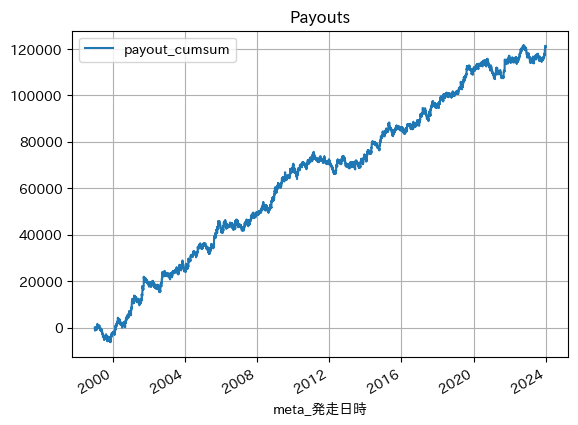

In [227]:
print(f"N bets: {len(bets)}")
payouts.assign(payout_cumsum=lambda x: x["payout"].cumsum()).plot(x="meta_発走日時", y="payout_cumsum", title="Payouts", grid=True);